# Análisis de grandes gastos 2025

In [1]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [2]:
conn = ConexionBD.obtener_conexion()

In [3]:
# Gastos 2025
query = """
    SELECT fecha_valor, importe, saldo, categoria, subcategoria, descripcion
    FROM bancapp.movimientos_mview
    WHERE fecha_valor >= '2025-01-01'
    ORDER BY fecha_valor
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

# Creamos el data frame de gastos
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria", 
                              "subcategoria", "descripcion"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

**Visualizamos la distribución de gasto, por encima y debajo de un umbral**

In [4]:
umbral = 300

In [5]:
df_gastos["tipo_gasto"] = df_gastos.importe.apply(lambda importe: "peque" if importe < umbral else "grande")

In [6]:
dfg_tipo_gasto = df_gastos.groupby("tipo_gasto")

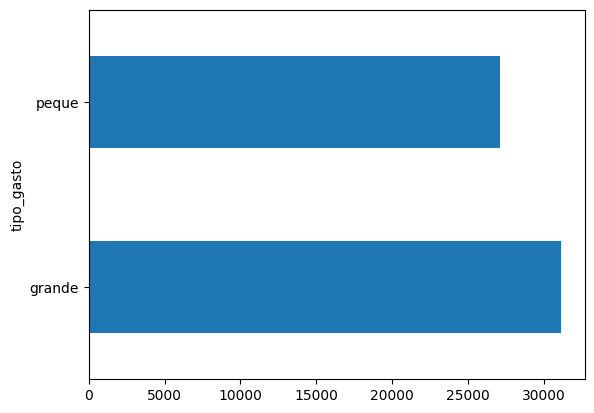

In [7]:
dfg_tipo_gasto.importe.sum().plot(kind="barh");

**Distribución**

In [8]:
dfg_tipo_gasto.importe.describe()

,count,mean,std,min,25%,50%,75%,max
tipo_gasto,,,,,,,,
grande,42.0,741.461429,1381.154558,310.53,319.5000,378.950,459.5,9000.0
peque,626.0,43.290160,51.509880,0.49,9.9925,24.985,54.0,291.0


## Gastos por tipo y categoria

In [9]:
dfg_tipo_categoria = df_gastos.groupby(["categoria", "tipo_gasto"]).importe.sum().unstack().fillna(0)

In [10]:
dfg_tipo_categoria

tipo_gasto,grande,peque
categoria,,
Alimentación,672.43,10505.41
Compras,1513.03,3095.42
Educación y salud,8085.12,1994.66
Hogar,0.00,2023.52
Inversión,0.00,22.90
Movimientos excluidos,3100.00,591.00
Ocio y viajes,771.43,1206.69
Otros gastos,16037.00,6839.02
Vehículo y transporte,962.37,821.02


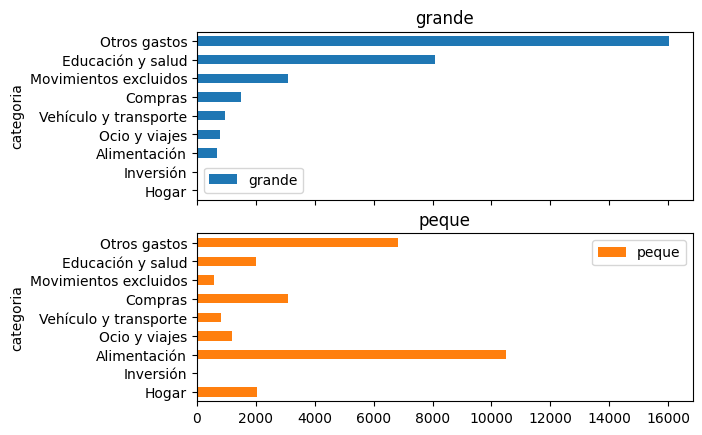

In [11]:
dfg_tipo_categoria.sort_values(by="grande").plot(kind="barh", subplots=True);

Gastos atípicos "grandes" en **Alimentación**

In [12]:
df_gastos[(df_gastos.tipo_gasto == "grande") & (df_gastos.categoria == "Alimentación")]

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,tipo_gasto
475,2025-08-18,8,2025,361.90,Alimentación,Supermercados y alimentación,Pago en MERCADONA BARBATE BARBATE ES,grande
495,2025-09-01,9,2025,310.53,Alimentación,Supermercados y alimentación,Pago en MERCADONA ONLINE WEB ES,grande


Listamos los grandes gastos de la categoría "Otros"

In [13]:
df_gastos[(df_gastos.tipo_gasto == "grande") & (df_gastos.categoria == "Otros gastos")]

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,tipo_gasto
94,2025-02-24,2,2025,2000.0,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Crespo Ac...,grande
170,2025-04-02,4,2025,2500.0,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Materiale...,grande
367,2025-06-23,6,2025,9000.0,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Pago mita...,grande
377,2025-06-30,6,2025,400.0,Otros gastos,Transferencias,Transferencia emitida a CDE RANDORI CUOTA Manu...,grande
387,2025-07-03,7,2025,429.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,grande
455,2025-08-07,8,2025,450.0,Otros gastos,Transferencias,Transferencia emitida a MCARMEN LOPEZ GUIJARRO...,grande
571,2025-10-07,10,2025,400.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,grande
622,2025-11-03,11,2025,462.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,grande
699,2025-12-06,12,2025,396.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...,grande


**Todos los gastos grandes**

In [14]:
df_gastos[(df_gastos.tipo_gasto == "grande")].sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion,tipo_gasto
367,2025-06-23,6,2025,9000.00,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Pago mita...,grande
170,2025-04-02,4,2025,2500.00,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Materiale...,grande
94,2025-02-24,2,2025,2000.00,Otros gastos,Transferencias,Transferencia emitida a Alicio Muñoz Crespo Ac...,grande
469,2025-08-16,8,2025,1250.00,Movimientos excluidos,Traspaso entre cuentas,Traspaso interno emitido Movimiento ING,grande
182,2025-04-04,4,2025,1250.00,Movimientos excluidos,Traspaso entre cuentas,Traspaso emitido Cuenta Nómina Mitad materiales,grande
28,2025-01-15,1,2025,962.37,Vehículo y transporte,Seguro de coche y moto,Recibo MUTUA MADRILENA AUTOMOVILISTA,grande
594,2025-10-22,10,2025,774.25,Compras,Compras (otros),Pago en MOGACAR PV FUENCARRAL FUENCARRAL ES,grande
136,2025-03-18,3,2025,738.78,Compras,Compras (otros),Pago en MOGACAR PV FUENCARRAL FUENCARRAL ES,grande
502,2025-09-02,9,2025,600.00,Movimientos excluidos,Traspaso entre cuentas,Traspaso interno emitido Movimiento ING,grande
237,2025-04-27,4,2025,499.00,Educación y salud,Educación,Pago en EL VALLE MADRID ES,grande
